In [5]:
import sacc
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import pickle
import emcee
import scipy.stats as st
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)
from getdist import plots, MCSamples, loadMCSamples
from getdist.mcsamples import MCSamplesFromCobaya

## 1. Read all chains

In [6]:
cha = loadMCSamples('chains_cobaya/chain_cobaya_all',
                    settings={'ignore_rows': 0.2})
ch0 = loadMCSamples('chains_cobaya/chain_cobaya_bin0',
                    settings={'ignore_rows': 0.2})
ch1 = loadMCSamples('chains_cobaya/chain_cobaya_bin1',
                    settings={'ignore_rows': 0.2})
ch2 = loadMCSamples('chains_cobaya/chain_cobaya_bin2',
                    settings={'ignore_rows': 0.2})
ch3 = loadMCSamples('chains_cobaya/chain_cobaya_bin3',
                    settings={'ignore_rows': 0.2})

## 2. Plot constraints
Triangle plot

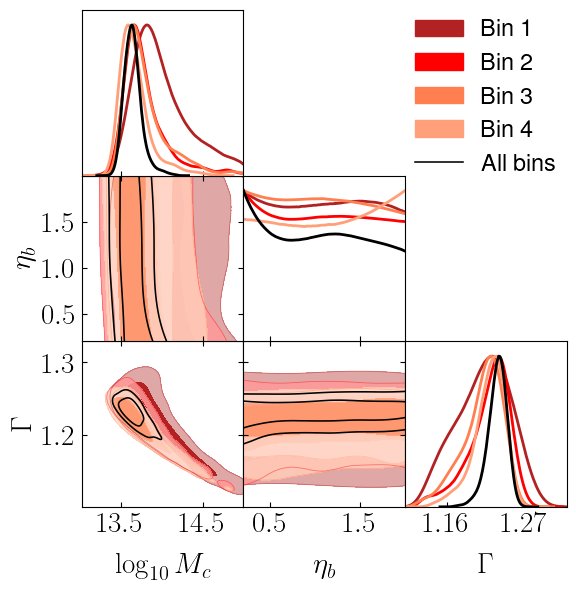

In [7]:
params = ['lMc', 'eta_b', 'gamma']
g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 24
g.settings.axes_fontsize = 24
g.settings.linewidth=2
g.settings.figure_legend_frame=False
g.triangle_plot([ch0, ch1, ch2, ch3, cha],
                params, filled=[True, True, True, True, False],
                legend_labels=[f'Bin {i+1}' for i in range(4)] + ['All bins'],
                line_args=[{'lw': 2, 'color':'firebrick'},
                           {'lw': 2, 'color':'red'},
                           {'lw': 2, 'color':'coral'},
                           {'lw': 2, 'color':'lightsalmon'},
                           {'lw': 2, 'color':'black'}],                     
                contour_colors=['firebrick', 'red', 'coral', 'lightsalmon', 'black'])
plt.savefig('triangle_main.pdf')

Rectangle plot

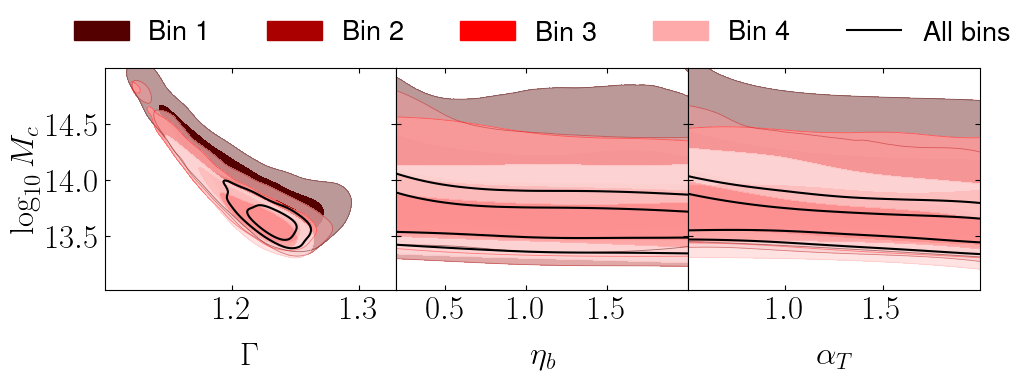

In [8]:
g = plots.get_subplot_plotter()
g.settings.fig_width_inch=10
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 24
g.settings.axes_fontsize = 24
g.settings.linewidth=2
g.settings.figure_legend_frame=False
g.rectangle_plot(['gamma','eta_b','alpha_T'],'lMc',
                 roots=[ch0, ch1, ch2, ch3, cha],
                 filled=[True, True, True, True, False],
                 legend_labels=[f'Bin {i+1}' for i in range(4)] + ['All bins'],
                 contour_colors=['#550000', '#AA0000', '#FF0000', '#FFAAAA', '#000000'],
                 line_args=[{'lw': 2, 'color':'#550000'},
                            {'lw': 2, 'color':'#AA0000'},
                            {'lw': 2, 'color':'#FF0000'},
                            {'lw': 2, 'color':'#FFAAAA'},
                            {'lw': 1.5, 'color':'black'}])
plt.savefig('rectangle_main.pdf', bbox_inches='tight')

## 3. $C_\ell$ plot

18.983611284557544 24 0.7528630630044759
24.785628280827815 24 0.417483935980255
19.36075876374783 24 0.7324863951476652
25.264137738157878 24 0.39152269036151033


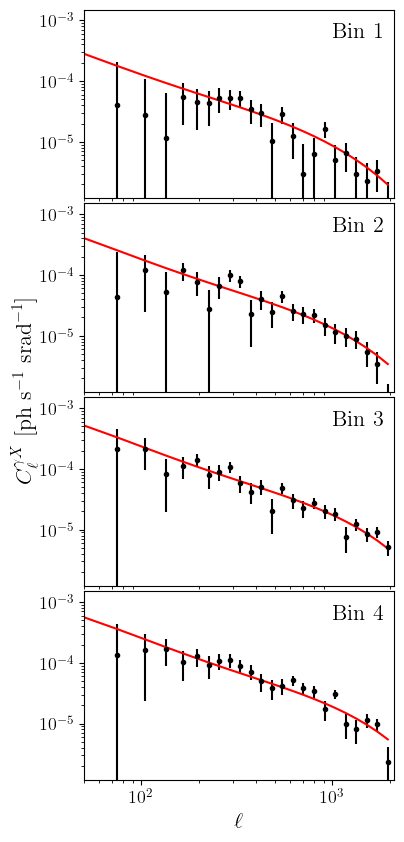

In [9]:
#lc = rx.ROSATxLike(params_vary=['logTAGN'],
#                   priors={'logTAGN': [7.5, 8.2]})
#t = lc.get_model(logTAGN=d['logTAGN'][np.argmin(d['chi2'][:, -1])])
lc = rx.ROSATxLike(params_vary=['lMc', 'gamma', 'alpha_T', 'eta_b'], bins=[0, 1, 2, 3])
imin = np.argmin(cha['chi2'])
t = lc.get_model(lMc=cha['lMc'][imin],
                 gamma=cha['gamma'][imin],
                 eta_b=cha['eta_b'][imin],
                 alpha_T=cha['alpha_T'][imin])

mosaic = """
A
B
C
D
"""
fig, axes = plt.subplot_mosaic(mosaic=mosaic, figsize=(4,10))
plt.subplots_adjust(hspace=0.03, wspace=0.03)
for i, a in enumerate(['A', 'B', 'C', 'D']):
    ax = axes[a]
    clm = lc.cl_meta[i]
    clt = t[i]
    r = clm['cld']-clt
    chi2 = np.dot(r, np.linalg.solve(clm['cov'], r))
    print(chi2, len(clt), 1-st.chi2.cdf(chi2, len(clt)))
    ax.errorbar(clm['ls'], clm['cld'], yerr=np.sqrt(np.diag(clm['cov'])), fmt='k.')
    ax.plot(clm['ls'], clt, 'r-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1.2E-6, 1.5E-3])
    ax.set_xlim([50, 2100])
    ax.tick_params(axis='both', labelsize=13)
    ax.text(0.8, 0.85, r'${\rm Bin\,\,%d}$'%(i+1), transform=ax.transAxes, fontsize=16)
axes['A'].set_xticks([])
axes['B'].set_xticks([])
axes['C'].set_xticks([])
#axes['D'].set_yticks([])
#fig.add_subplot(111, frameon=False)
#for m in ['A', 'B', 'C', 'D']:
#plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
fig.supylabel(r'$C_\ell^{\gamma X}\,\,[{\rm ph\,\,s^{-1}\,\,{\rm srad}^{-1}}]$',
              fontsize=16, x=-0.06)
for m in ['C', 'D']:
    axes[m].set_xlabel(r'$\ell$', fontsize=16)
plt.savefig("allcl.pdf", bbox_inches='tight')

In [10]:
for ch, bins, data in zip([cha, ch0, ch1, ch2, ch3],
                          [[0, 1, 2, 3], [0], [1], [2], [3]],
                          ['All bins', 'Bin 1', 'Bin 2', 'Bin 3', 'Bin 4']):
    # Find minimum chi2
    imin = np.argmin(ch['chi2'])
    chi2 = ch['chi2'][imin]
    # Get theory at minimum chi2
    lc = rx.ROSATxLike(params_vary=['lMc', 'gamma', 'alpha_T', 'eta_b'], bins=bins)
    t = np.concatenate(lc.get_model(lMc=ch['lMc'][imin], gamma=ch['gamma'][imin],
                                    eta_b=ch['eta_b'][imin], alpha_T=ch['alpha_T'][imin])).flatten()
    d = lc.data
    nd = len(d)

    # Get S/N
    chi2_0 = np.dot(d, np.dot(lc.inv_cov, d))
    sn = np.sqrt(chi2_0-chi2)
    sn_t = '%.1lf' % sn
    p = 1-st.chi2.cdf(chi2, nd-4)
    chi2_st = "%.1lf" % chi2
    p_st = "%.2lf" % p
    lMc_st = ch.getLatex('lMc')
    gamma_st = ch.getLatex('gamma')
    print(data, lMc_st, gamma_st, chi2_st, p_st, sn_t)

All bins lMc = 13.643^{+0.081}_{-0.12} gamma = 1.231^{+0.015}_{-0.011} 80.8 0.79 25.0
Bin 1 \log_{10}M_c = 13.99^{+0.19}_{-0.42} \Gamma = 1.211^{+0.046}_{-0.034} 16.6 0.68 7.5
Bin 2 lMc = 13.79^{+0.10}_{-0.29} gamma = 1.219^{+0.035}_{-0.018} 24.5 0.22 12.4


Bin 3 lMc = 13.797^{+0.092}_{-0.31} gamma = 1.210^{+0.036}_{-0.018} 19.0 0.52 16.5
Bin 4 lMc = 13.668^{+0.096}_{-0.21} gamma = 1.219^{+0.026}_{-0.015} 24.2 0.23 15.8


## 4. BAHAMAs constraints

In [11]:
d = np.load("constraints_1d.npz")
probs = np.exp(-0.5*(d['chi2']-np.amin(d['chi2'], axis=0)))
logTAGNs = d['logTAGN']
lMcs = d['lMc']
alpha_Ts = d['alpha_T']
gammas = d['gamma']

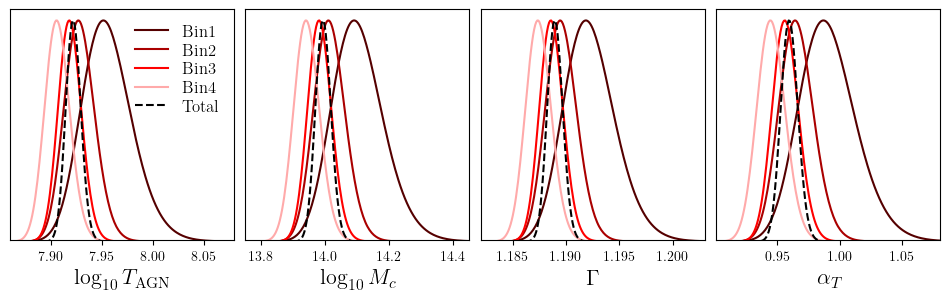

In [12]:
fig, axes = plt.subplots(1, 4,
                         figsize=(12, 3),
                         sharex=False,
                         sharey=True)
plt.subplots_adjust(wspace=0.05)
axes = axes.flatten()
cols = ['#550000', '#AA0000', '#FF0000', '#FFAAAA', '#000000']

#=[{'lw': 2, 'color':'firebrick'},
#                           {'lw': 2, 'color':'red'},
#                           {'lw': 2, 'color':'coral'},
#                           {'lw': 2, 'color':'lightsalmon'},
#                           {'lw': 2, 'color':'black'}],  
labels = [r'${\rm Bin %d}$' % (i+1) for i in range(4)] + [r'${\rm Total}$']
lss = ['-']*4 + ['--']
for p, c, ls, lab in zip(probs.T, cols, lss, labels):
    axes[0].plot(logTAGNs, p, ls, c=c, label=lab)
    axes[0].set_xlabel(r'$\log_{10}T_{\rm AGN}$', fontsize=16)
    axes[1].plot(lMcs, p, ls, c=c, label=lab)
    axes[1].set_xlabel(r'$\log_{10}M_c$', fontsize=16)
    axes[2].plot(gammas, p, ls, c=c, label=lab)
    axes[2].set_xlabel(r'$\Gamma$', fontsize=16)
    axes[3].plot(alpha_Ts, p, ls, c=c, label=lab)
    axes[3].set_xlabel(r'$\alpha_T$', fontsize=16)
axes[0].legend(frameon=False, fontsize=12, labelspacing=0.2)
axes[0].set_xlim([7.86, 8.08])
axes[1].set_xlim([13.75, 14.45])
axes[2].set_xlim([1.182, 1.203])
axes[3].set_xlim([0.901, 1.08])
for ax in axes:
    ax.set_ylim([0.005, 1.05])
    ax.set_yticks([])
plt.savefig('constraints_BAHAMAS.pdf', bbox_inches='tight')

In [14]:
lTAGN = d['logTAGN']

lc = rx.ROSATxLike(params_vary=['logTAGN'], bins=[0, 1, 2, 3])
ts = lc.get_model(logTAGN=lTAGN[np.argmax(probs[:, -1])])

for i, (p, bins) in enumerate(zip(probs.T, [[0], [1], [2], [3], [0, 1, 2, 3]])):
    m = np.sum(p*lTAGN)/np.sum(p)
    s = np.sqrt(np.sum(p*lTAGN**2)/np.sum(p)-m**2)
    print(f"%.3lf \\pm %.3lf" % (m, s))
    bf = lTAGN[np.argmax(p)]
    lc = rx.ROSATxLike(params_vary=['logTAGN'], bins=bins)
    t = np.concatenate(lc.get_model(logTAGN=bf)).flatten()
    chi2 = np.dot(t-lc.data, np.dot(lc.inv_cov, t-lc.data))
    pte = 1-st.chi2.cdf(chi2, len(t)-1)
    print(chi2, len(t), pte)
    if i < 4:
        tt = ts[i]
        chi2 = np.dot(tt-lc.data, np.dot(lc.inv_cov, tt-lc.data))
        pte = 1-st.chi2.cdf(chi2, len(tt)-1)
        print(chi2, len(tt), pte)

7.956 \pm 0.025
17.193952286386846 24 0.7996265572758002
19.09893469942606 24 0.6954675251760601
7.929 \pm 0.015
27.19304178566278 24 0.2478404788690679
27.335502353572274 24 0.24195613504980473
7.919 \pm 0.011
19.73276587322592 24 0.6579739877240935
19.822803379170686 24 0.6525761143446547
7.907 \pm 0.012
27.367958949402663 24 0.2406289857859627
28.95154062721147 24 0.18192184735698058
7.922 \pm 0.007
87.20097663331583 96 0.7031016360102612


In [9]:
chd = loadMCSamples('chains_cobaya/desy3wl_k1000_hsc_baryons_nocuts_nla_nside4096_lmin20_lmin100_lmin300_GNG',
                    settings={'ignore_rows': 0.3})
chd.addDerived(chd['M_c'], name='lMc', label='\log_{10}M_c')

In [10]:
lMa, pa = np.loadtxt("arico.csv", unpack=True, delimiter=',')
i = np.argsort(lMa)
lMa = lMa[i]
pa = pa[i]
pa /= np.amax(pa)

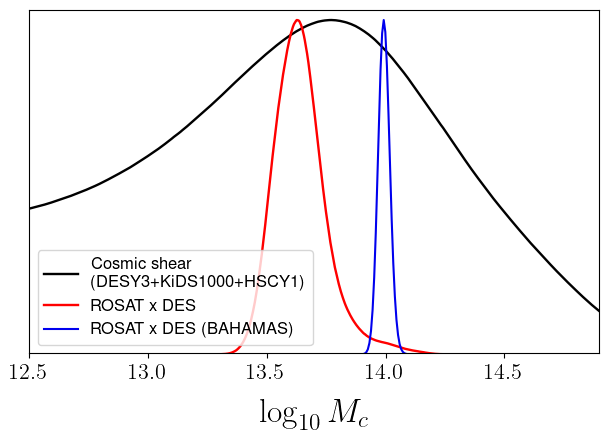

In [11]:
g = plots.get_single_plotter(width_inch=6)
g.settings.legend_fontsize = 12
g.settings.axes_labelsize = 24
g.settings.axes_fontsize = 16
g.plot_1d([chd, cha], 'lMc')
d = np.load("constraints_1d.npz")
plt.plot(d['lMc'], np.exp(-0.5*(d['chi2'][:, -1]-np.amin(d['chi2'][:, -1]))), '-', c='#0000EE')
#g.plot_1d(chd, 'M_c', colors=['#EE0000'])
#plt.plot(lMa, pa, '-', c='#EE0000')
plt.xlim([12.5, 14.9])
plt.ylim([0.003, 1.03])
g.add_legend(legend_labels=['Cosmic shear\n (DESY3+KiDS1000+HSCY1)',
                            'ROSAT x DES',
                            'ROSAT x DES (BAHAMAS)'],
             legend_loc='lower left', frameon=False);
plt.savefig("Mcfocus.pdf", bbox_inches='tight')